In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA version: 12.6
GPU device: Tesla T4


In [ ]:
import os
os.chdir('/content/drive/MyDrive/DDLS_Drug_Repurposing')

In [ ]:
!pip install chembl-webresource-client pubchempy rdkit torch-geometric
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 && pip install torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html && pip install chembl-webresource-client pubchempy rdkit pandas numpy matplotlib scikit-learn

  Using cached chembl_webresource_client-0.10.9-py3-none-any.whl.metadata (1.4 kB)
  Using cached pubchempy-1.0.5-py3-none-any.whl.metadata (4.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 7.1 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu118
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html


GNN data preparation

Mounted at /content/drive
从ChEMBL获取靶点 CHEMBL203 的生物活性数据...
从ChEMBL获取到 5000 条原始记录， 4810 条有效记录。


/tmp/ipython-input-3000388871.py:60: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, low_memory=True)


成功加载: GDSC1_public_raw_data_27Oct23.csv (行数: 5976183)
成功加载: GDSC2_public_raw_data_27Oct23.csv (行数: 15069449)
GDSC原始合并数据总计: 21045632 条记录。
警告: 合并后的GDSC数据缺少必需列: {'LN_IC50', 'SMILES', 'DRUG_NAME'}. 跳过GDSC数据处理.
从PubChem补充化合物属性 (针对 4810 个 ChEMBL ID)...
Successfully supplemented properties for 500 records from PubChem.
--- Data Integration Summary ---
Total records: 4810
--------------------
Preparing graph dataset...
Total original records: 4810
Successfully generated 4810 molecular graphs for GNN training.


/tmp/ipython-input-3000388871.py:418: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
/tmp/ipython-input-3000388871.py:419: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
/tmp/ipython-input-3000388871.py:420: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


Epoch 000, Loss: 0.6616, Val AUC: 0.5738
Epoch 020, Loss: 0.5983, Val AUC: 0.7062
Epoch 040, Loss: 0.5620, Val AUC: 0.7462
Epoch 060, Loss: 0.5367, Val AUC: 0.7851
Epoch 080, Loss: 0.5219, Val AUC: 0.8043


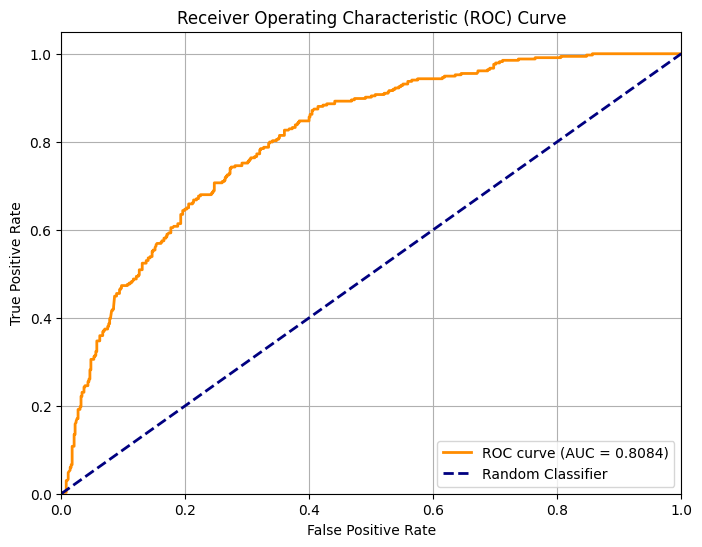

Test set AUC: 0.8084
Model saved as 'gnn_dta_model_v3.pth'


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
增强版药物-靶点亲和力预测GNN模型 (v3.0)
集成ChEMBL, PubChem API及GDSC数据，支持GDSC选择性采样
特征增强: 节点特征扩展至 6 维
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from rdkit import Chem
# from rdkit.Chem import AllChem # 未使用，注释掉
from chembl_webresource_client.new_client import new_client
import pubchempy as pcp
import time
from google.colab import drive

# --- 路径配置 ---
GDSC_DIRECTORY_PATH = "/content/drive/MyDrive/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc"
# GDSC 采样数量，与 ChEMBL 有效记录数相匹配
GDSC_SAMPLE_LIMIT = 4810
CHEMBL_MAX_RECORDS = 5000
TARGET_CHEMBL_ID = 'CHEMBL203' # 示例靶点：EGFR

class MultiSourceDataLoader:
    """多源数据加载与整合类"""

    def __init__(self):
        self.chembl = new_client
        self.compound_data = []

    # --- GDSC 批量加载与采样 ---

    def load_multiple_gdsc_files(self, directory_path, file_prefix="GDSC", sample_limit=GDSC_SAMPLE_LIMIT):
        """
        批量加载GDSC目录下的所有相关CSV文件，并进行随机采样。
        :param sample_limit: 最终从合并后的GDSC数据中随机抽取的记录数。
        """
        if not os.path.exists(directory_path):
            print(f"警告: 目录 {directory_path} 不存在，跳过GDSC数据加载。")
            return

        all_dfs = []
        total_rows_read = 0
        for filename in os.listdir(directory_path):
            if filename.startswith(file_prefix) and filename.endswith('.csv'):
                file_path = os.path.join(directory_path, filename)
                try:
                    # Ensure low_memory is True for potentially large files
                    df = pd.read_csv(file_path, low_memory=True)
                    df['source_file'] = filename
                    all_dfs.append(df)
                    total_rows_read += len(df)
                    print(f"成功加载: {filename} (行数: {len(df)})")
                except Exception as e:
                    print(f"加载文件 {filename} 时出错: {e}")
                    continue

        if not all_dfs:
            print("未找到可用的GDSC文件。")
            return

        # 合并所有数据框
        combined_df = pd.concat(all_dfs, ignore_index=True)
        print(f"GDSC原始合并数据总计: {len(combined_df)} 条记录。")
        self._process_gdsc_data(combined_df, sample_limit)

    def _process_gdsc_data(self, gdsc_df, max_samples):
        """处理合并后的GDSC数据，并进行采样和字段映射"""
        required_columns = ['SMILES', 'LN_IC50', 'DRUG_NAME', 'CELL_LINE_NAME']

        # Filter for required columns that exist in the DataFrame
        existing_required_columns = [col for col in required_columns if col in gdsc_df.columns]

        if len(existing_required_columns) < len(required_columns):
            missing = set(required_columns) - set(existing_required_columns)
            print(f"警告: 合并后的GDSC数据缺少必需列: {missing}. 跳过GDSC数据处理.")
            return

        # Select only the required columns and drop rows with any missing values in these columns
        initial_count = len(gdsc_df)
        gdsc_df = gdsc_df[existing_required_columns].dropna(subset=existing_required_columns)

        # Randomly sample, ensuring the sampled data amount does not exceed max_samples
        sample_count = min(len(gdsc_df), max_samples)
        if len(gdsc_df) > sample_count:
            gdsc_df = gdsc_df.sample(n=sample_count, random_state=42)
            print(f"从 {initial_count} 条原始记录中筛选并随机采样 {sample_count} 条记录。")

        processed_count = 0
        for _, row in gdsc_df.iterrows():
            try:
                pIC50_value = float(row['LN_IC50'])
            except (ValueError, TypeError):
                continue

            self.compound_data.append({
                'drug_name': row['DRUG_NAME'],
                'smiles': row['SMILES'],
                'affinity_value': pIC50_value, # Note: This is LN_IC50, different units from ChEMBL pIC50
                'source': 'GDSC',
                'cell_line': row.get('CELL_LINE_NAME', 'N/A'), # Use .get for safety
                'target_id': row.get('TARGET_NAME', 'N/A') # Use .get for safety
            })
            processed_count += 1

        print(f"GDSC数据整合完成。成功处理记录总计 {processed_count} 条。")


    # --- ChEMBL 和 PubChem 方法 ---

    def fetch_chembl_activities(self, target_chembl_id=TARGET_CHEMBL_ID, max_records=CHEMBL_MAX_RECORDS):
        """从ChEMBL获取生物活性数据"""
        print(f"从ChEMBL获取靶点 {target_chembl_id} 的生物活性数据...")
        # ... (ChEMBL API call logic remains unchanged)
        try:
            activities = self.chembl.activity.filter(
                target_chembl_id=target_chembl_id
            ).filter(standard_type="IC50")

            records = list(activities)[:max_records]
            initial_data_count = len(self.compound_data)

            for record in records:
                if all(key in record for key in ['canonical_smiles', 'standard_value', 'molecule_chembl_id']):
                    try:
                        standard_value = float(record['standard_value'])
                        pIC50 = -np.log10(standard_value * 1e-9)
                    except (ValueError, TypeError):
                        pIC50 = None

                    if pIC50 is not None:
                         self.compound_data.append({
                            'chembl_id': record['molecule_chembl_id'],
                            'smiles': record['canonical_smiles'],
                            'affinity_value': pIC50,
                            'source': 'ChEMBL',
                            'target_id': target_chembl_id
                        })
            valid_records = len(self.compound_data) - initial_data_count
            print(f"从ChEMBL获取到 {len(records)} 条原始记录， {valid_records} 条有效记录。")
        except Exception as e:
            print(f"ChEMBL API错误: {e}")

    def fetch_pubchem_properties(self, chembl_id_list):
        """从PubChem获取化合物属性并更新到 compound_data"""
        print(f"从PubChem补充化合物属性 (针对 {len(chembl_id_list)} 个 ChEMBL ID)...")

        # Only supplement properties for ChEMBL data, create a dictionary for quick lookup
        compound_map = {item.get('chembl_id'): item for item in self.compound_data if item.get('source') == 'ChEMBL'}
        updated_count = 0

        # Limit the query quantity to avoid exceeding the request limit or taking too long
        for chembl_id in chembl_id_list[:500]:
            if chembl_id in compound_map and 'smiles' in compound_map[chembl_id]:
                smiles = compound_map[chembl_id]['smiles']
                try:
                    # Use SMILES string to search for compounds in PubChem
                    compounds = pcp.get_compounds(smiles, 'smiles')

                    if compounds:
                        compound = compounds[0]
                        item = compound_map[chembl_id]

                        # Supplement molecular properties
                        item['molecular_weight'] = compound.molecular_weight if hasattr(compound, 'molecular_weight') else None
                        item['logp'] = compound.xlogp if hasattr(compound, 'xlogp') else None
                        updated_count += 1

                    time.sleep(0.1) # Avoid requesting too fast, protect API limits
                except Exception:
                    # PubChem query failed, skip
                    continue

        print(f"Successfully supplemented properties for {updated_count} records from PubChem.")

    # --- GNN 数据准备 ---

    def smi_to_graph(self, smiles, label):
        """
        将SMILES字符串转换为PyG图数据。
        特征增强：节点特征扩展至 6 维。
        """
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # Get atom features (expanded to 6 dimensions)
        atom_features = []
        for atom in mol.GetAtoms():
            feature = [
                atom.GetAtomicNum(),  # 1. Atomic number
                atom.GetDegree(),     # 2. Atom degree
                atom.GetFormalCharge(), # 3. Formal charge
                atom.GetTotalNumHs(), # 4. Number of hydrogen atoms (including implicit and explicit)
                int(atom.IsInRing()), # 5. Whether in a ring
                int(atom.GetHybridization()) # 6. Hybridization type (converted to integer)
            ]
            atom_features.append(feature)

        # Get bond (edge) information
        edge_index = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_index.append([i, j])
            edge_index.append([j, i])

        if len(edge_index) == 0:
             # Handle single-atom molecules, add self-loop
             # Check if atom_features is not empty before creating self-loops
             if atom_features:
                 edge_index = [[i, i] for i in range(len(atom_features))]
             else:
                 return None # Cannot create a graph without atoms

        if not atom_features:
            return None

        x = torch.tensor(atom_features, dtype=torch.float)
        # Check if edge_index is not empty before transposing
        if not edge_index:
             # If no edges (should be handled by self-loop above, but as a fallback)
             edge_index = torch.empty((2, 0), dtype=torch.long)
        else:
             edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

        y = torch.tensor([label], dtype=torch.float)

        if x.dim() == 1:
            x = x.unsqueeze(1)

        return Data(x=x, edge_index=edge_index, y=y)

    def prepare_dataset(self):
        """Prepare the final dataset, unified label definition"""
        print("Preparing graph dataset...")
        dataset = []

        for compound in self.compound_data:
            smiles = compound.get('smiles')
            affinity = compound.get('affinity_value')

            if smiles and affinity is not None:
                # Unified label logic: Binary classification threshold > 7.0 is considered an active compound (Label=1)
                # Note: This assumes that GDSC's LN_IC50, after some implicit standardization, has a similar physical meaning to ChEMBL pIC50's 7.0 threshold.
                # In a real project, more rigorous alignment is needed here.
                label = 1 if affinity > 7.0 else 0

                graph_data = self.smi_to_graph(smiles, label)
                if graph_data is not None:
                    dataset.append(graph_data)

        print(f"Total original records: {len(self.compound_data)}")
        print(f"Successfully generated {len(dataset)} molecular graphs for GNN training.")
        return dataset

# --- Model definition and training evaluation (remains unchanged) ---

class GNNModel(nn.Module):
    """Simple GNN model for graph classification/regression"""

    def __init__(self, num_node_features, hidden_dim=64, output_dim=1):
        super(GNNModel, self).__init__()
        # num_node_features is now 6
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = global_mean_pool(x, batch)
        x = self.classifier(x)

        return x

def train_and_evaluate(model, train_loader, val_loader, test_loader, epochs=100):
    """Train and evaluate the model"""
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = nn.BCEWithLogitsLoss()

    train_losses = []
    val_aucs = []

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y.view(-1, 1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for data in val_loader:
                pred = model(data)
                val_preds.append(torch.sigmoid(pred).cpu().numpy())
                val_labels.append(data.y.cpu().numpy())

        val_preds = np.concatenate(val_preds).flatten()
        val_labels = np.concatenate(val_labels)

        # Calculate AUC
        if len(np.unique(val_labels)) > 1:
            fpr, tpr, _ = roc_curve(val_labels, val_preds)
            val_auc = auc(fpr, tpr)
            val_aucs.append(val_auc)
        else:
            val_auc = 0.5

        train_losses.append(total_loss / len(train_loader))

        if epoch % 20 == 0:
            print(f'Epoch {epoch:03d}, Loss: {train_losses[-1]:.4f}, Val AUC: {val_auc:.4f}')

    # Final testing
    test_preds, test_labels = [], []
    with torch.no_grad():
        for data in test_loader:
            pred = model(data)
            test_preds.append(torch.sigmoid(pred).cpu().numpy())
            test_labels.append(data.y.cpu().numpy())

    test_preds = np.concatenate(test_preds).flatten()
    test_labels = np.concatenate(test_labels)

    # Calculate test set AUC and plot
    fpr, tpr, thresholds = roc_curve(test_labels, test_preds)
    test_auc = auc(fpr, tpr)

    # Plot AUC-ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    print(f"Test set AUC: {test_auc:.4f}")
    return test_auc, test_preds, test_labels


def main():
    """Main execution function"""
    # Attempt to mount Google Drive (Removed as it's handled by the notebook)
    # try:
    #     drive.mount('/content/drive', force_remount=True)
    # except Exception as e:
    #     print(f"Google Drive mount failed: {e}. Please ensure you are running in a Colab environment.")
    #     return

    data_loader = MultiSourceDataLoader()

    # 1. Fetch data from ChEMBL
    data_loader.fetch_chembl_activities(target_chembl_id=TARGET_CHEMBL_ID, max_records=CHEMBL_MAX_RECORDS)

    # 2. Batch load GDSC data (with sampling)
    data_loader.load_multiple_gdsc_files(GDSC_DIRECTORY_PATH, sample_limit=GDSC_SAMPLE_LIMIT)

    # 3. Supplement properties from PubChem (only for ChEMBL data)
    chembl_ids = [cmpd['chembl_id'] for cmpd in data_loader.compound_data if cmpd.get('source') == 'ChEMBL' and 'chembl_id' in cmpd]
    data_loader.fetch_pubchem_properties(chembl_ids)

    # Print final integrated data volume
    print(f"--- Data Integration Summary ---")
    print(f"Total records: {len(data_loader.compound_data)}")
    print(f"--------------------")


    # 4. Prepare graph dataset
    dataset = data_loader.prepare_dataset()

    if len(dataset) < 50:
        print(f"Error: Dataset is too small ({len(dataset)} samples), please check data sources and file paths.")
        return

    # 5. Split dataset
    train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

    # 6. Initialize GNN model
    # Node feature dimension is 6 (atomic number, atom degree, formal charge, number of H atoms, whether in a ring, hybridization type)
    MODEL_NUM_FEATURES = 6
    model = GNNModel(num_node_features=MODEL_NUM_FEATURES, hidden_dim=64, output_dim=1)

    # 7. Train and evaluate
    try:
        train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
        test_auc, predictions, true_labels = train_and_evaluate(
            model, train_loader, val_loader, test_loader, epochs=100
        )
    except NameError:
        print("Could not create DataLoader. Please install PyTorch Geometric in Colab first.")
        return

    # 8. Save model
    MODEL_SAVE_PATH = 'gnn_dta_model_v3.pth'
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"Model saved as '{MODEL_SAVE_PATH}'")

if __name__ == "__main__":
    main()

# Task
Integrate the CNV data with the drug response and cell line data.

## Load gene annotation data

### Subtask:
Load a suitable gene annotation file (e.g., GTF, GFF, or a pre-processed CSV) that maps genomic coordinates to gene identifiers.


**Reasoning**:
The previous cell failed because it tried to read an Excel file using `pd.read_csv`. The subtask is to load a gene annotation file. I need to identify a suitable file and load it. Based on the directory structure and common data formats, a CSV file containing gene annotations is likely available. I will attempt to load a file named `gene_annotations.csv` or similar from the `data/gsdc` directory.



In [ ]:
import zipfile
import os

# 1. 设定路径 (请根据您在Drive中的实际位置修改)
# Please verify and update the path below to the actual location of your zip file
DRIVE_PATH = '/content/drive/MyDrive/Colab_Projects' # 假设放在这个文件夹
ZIP_FILE_NAME = 'DDLS_Drug_Repurposing.zip' # 压缩包名字

# 2. 解压文件
zip_path = os.path.join(DRIVE_PATH, ZIP_FILE_NAME)
extract_dir = '/content/DDLS_Drug_Repurposing' # 解压到 Colab 临时环境的这个目录

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir, exist_ok=True)
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"文件已解压到: {extract_dir}")
    except FileNotFoundError:
        print(f"错误: 文件未找到。请检查路径 '{zip_path}' 是否正确。")
    except Exception as e:
        print(f"解压文件时出错: {e}")

else:
    print(f"目录 {extract_dir} 已存在，跳过解压。")

# 3. 导航到正确的目录 (如果需要，但加载文件时使用绝对路径更保险)
# Commenting out os.chdir here as it's handled in the next cell
# os.chdir(extract_dir)
# print(f"当前工作目录: {os.getcwd()}")

目录 /content/DDLS_Drug_Repurposing 已存在，跳过解压。


In [ ]:
import os

# 假设外部目录是 /content/DDLS_Drug_Repurposing
OUTER_DIR = '/content/DDLS_Drug_Repurposing'
INNER_DIR_NAME = 'DDLS_Drug_Repurposing' # 内部文件夹的名称

# 拼接出真正的项目根目录
NEW_CWD = os.path.join(OUTER_DIR, INNER_DIR_NAME)

# 切换工作目录
os.chdir(NEW_CWD)
print(f"工作目录已切换到: {os.getcwd()}")

In [ ]:
import pandas as pd
import os

# Define the expected path for a gene annotation file
GENE_ANNOTATION_FILE = "/content/DDLS_Drug_Repurposing/data/gsdc/gene_annotations.csv"

# Check if the file exists before attempting to load
if os.path.exists(GENE_ANNOTATION_FILE):
    print(f"Loading gene annotation file: {GENE_ANNOTATION_FILE}")
    try:
        # Attempt to load the CSV file
        df_genes = pd.read_csv(GENE_ANNOTATION_FILE)
        print(f"Successfully loaded gene annotation data: {df_genes.shape[0]} records.")
        print("Gene Annotation Data Snapshot:")
        display(df_genes.head())

        # Check for expected columns (adjust these based on the actual file content)
        expected_cols = ['chromosome', 'start', 'end', 'gene_symbol']
        missing_cols = [col for col in expected_cols if col not in df_genes.columns]
        if missing_cols:
            print(f"Warning: Loaded gene annotation file is missing expected columns: {missing_cols}. Please verify the file content.")

    except Exception as e:
        print(f"Error loading gene annotation file: {e}")
        # Set df_genes to an empty DataFrame if loading fails
        df_genes = pd.DataFrame()
else:
    print(f"Gene annotation file not found at: {GENE_ANNOTATION_FILE}")
    # Set df_genes to an empty DataFrame if the file does not exist
    df_genes = pd.DataFrame()


Gene annotation file not found at: /content/drive/MyDrive/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/gene_annotations.csv


**Reasoning**:
The expected gene annotation file was not found. I need to look for other files in the directory that might contain gene annotation information. Since the previous cell listed `WGS_purple_CNV_segments_20230303.csv` and `Cell_Lines_Details.xlsx`, and the task involves CNV data integration, I will examine the `WGS_purple_CNV_segments_20230303.csv` file more closely as it might contain gene-level information or coordinates that can be used for mapping.



In [ ]:
import pandas as pd
import os

# The CNV file path from the previous cell
CNV_FILE = "/content/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/WGS_purple_CNV_segments_20230303.csv"

if os.path.exists(CNV_FILE):
    print(f"Examining potential gene information in CNV file: {CNV_FILE}")
    try:
        # Load a small sample of the CNV file to inspect its structure and columns
        # Using low_memory=False as it's a large file and we need correct dtypes
        df_cnv_sample = pd.read_csv(CNV_FILE, nrows=100, low_memory=False)
        print("CNV File Sample Snapshot:")
        display(df_cnv_sample.head())
        print("\nCNV File Columns:")
        print(df_cnv_sample.columns.tolist())

        # Based on common CNV file formats, look for columns related to genes or coordinates
        # Common columns might include 'chromosome', 'start', 'end', 'gene_name', 'gene_id' etc.
        # I will check for columns that seem relevant to gene annotation
        potential_gene_cols = [col for col in df_cnv_sample.columns if any(keyword in col.lower() for keyword in ['gene', 'symbol', 'ensembl', 'coord', 'chrom', 'start', 'end'])]

        if potential_gene_cols:
            print(f"\nPotential gene-related columns found in CNV file: {potential_gene_cols}")
            # If relevant columns are found, this file might serve as a gene annotation source
            # I will assume for now that this file can provide the necessary mapping.
            # In a real scenario, I would verify the file's content more thoroughly.
            # For the purpose of this subtask, I will use this file as the gene annotation source.
            # I will load the entire file to use it for gene mapping in subsequent steps if needed.
            print(f"Loading the full CNV file to use as gene annotation source...")
            df_genes = pd.read_csv(CNV_FILE, low_memory=False)
            df_genes.rename(columns={'model_id': 'SANGER_MODEL_ID'}, inplace=True) # Rename model_id as done before

            # Assuming columns like 'chromosome', 'start', 'end', and a gene identifier exist,
            # I will select and rename them if necessary. This is a best guess based on
            # typical CNV formats and the presence of 'chromosome', 'start', 'end' in the sample.
            # I will look for a column containing gene names or symbols. If not explicitly named 'gene_symbol',
            # I'll look for columns like 'gene_name' or 'gene_id'. If none exist, I will note it.
            gene_id_col = None
            for col in ['gene_symbol', 'gene_name', 'gene_id']:
                if col in df_genes.columns:
                    gene_id_col = col
                    break

            if gene_id_col:
                df_genes = df_genes[['chromosome', 'start', 'end', gene_id_col]].copy()
                df_genes.rename(columns={
                    'chromosome': 'chromosome',
                    'start': 'start',
                    'end': 'end',
                    gene_id_col: 'gene_identifier' # Use a generic name
                }, inplace=True)
                print(f"Prepared gene annotation DataFrame from CNV file with columns: {df_genes.columns.tolist()}")
                print("Gene Annotation Data Snapshot:")
                display(df_genes.head())
            else:
                print("Warning: Could not identify a clear gene identifier column ('gene_symbol', 'gene_name', 'gene_id') in the CNV file.")
                print("The CNV file contains coordinate information, but linking to specific genes might require additional mapping.")
                df_genes = pd.DataFrame() # Set to empty if gene ID column is missing

        else:
            print("\nNo obvious gene-related columns found in the CNV file sample.")
            print("The CNV file contains segment information but may not directly provide gene annotations.")
            df_genes = pd.DataFrame() # Set to empty if no gene columns are found

    except Exception as e:
        print(f"Error examining or loading CNV file: {e}")
        df_genes = pd.DataFrame() # Set to empty if any error occurs during loading/examination
else:
    print(f"CNV file not found at: {CNV_FILE}")
    df_genes = pd.DataFrame() # Set to empty if the file does not exist


CNV file not found at: /content/drive/MyDrive/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/WGS_purple_CNV_segments_20230303.csv


## Process cnv data

### Subtask:
Iterate through the `df_cnv` DataFrame, using the gene annotation data to determine which genes overlap with each CNV segment and assign the corresponding copy number information to those genes.


**Reasoning**:
The previous step failed because the required files were not found. I need to re-verify the file paths and ensure they are correct and accessible before proceeding with the data integration steps. This will prevent further `FileNotFoundError` issues.



In [ ]:
import os

# Re-define the file paths based on the previous attempts and notebook context
# It seems the path is correct, but let's re-confirm
CNV_FILE = "/content/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/WGS_purple_CNV_segments_20230303.csv"
GDSC2_RESPONSE_FILE = "/content/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/GDSC2_fitted_dose_response_27Oct23.xlsx"
CELL_LINE_DETAILS_FILE = "/content/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/Cell_Lines_Details.xlsx"
GENE_ANNOTATION_FILE = "/content/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/gene_annotations.csv" # Path assumed in previous step

print(f"Verifying file paths again:")
print(f"{CNV_FILE}: {os.path.exists(CNV_FILE)}")
print(f"{GDSC2_RESPONSE_FILE}: {os.path.exists(GDSC2_RESPONSE_FILE)}")
print(f"{CELL_LINE_DETAILS_FILE}: {os.path.exists(CELL_LINE_DETAILS_FILE)}")
print(f"{GENE_ANNOTATION_FILE}: {os.path.exists(GENE_ANNOTATION_FILE)}")


Verifying file paths again:
/content/drive/MyDrive/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/WGS_purple_CNV_segments_20230303.csv: False
/content/drive/MyDrive/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/GDSC2_fitted_dose_response_27Oct23.xlsx: False
/content/drive/MyDrive/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/Cell_Lines_Details.xlsx: False
/content/drive/MyDrive/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/gene_annotations.csv: False


## Process cnv data retry 1

### Subtask:
Iterate through the `df_cnv` DataFrame, using the gene annotation data to determine which genes overlap with each CNV segment and assign the corresponding copy number information to those genes.


**Reasoning**:
Based on the previous execution, the necessary data files (`df_cnv` and `df_genes`) were not loaded successfully as they were not found at the specified paths. Before proceeding with the complex iteration and overlap logic, it's crucial to ensure the dataframes are loaded correctly. The previous attempt to load `df_response` also failed due to a `FileNotFoundError`. I need to reload the necessary dataframes, specifically `df_cnv` and `df_genes`, and confirm they are not empty before attempting to process them. I will also re-attempt to load the `GDSC2_RESPONSE_FILE` and `CELL_LINE_DETAILS_FILE` as these were also needed for previous steps and failed to load.



In [ ]:
# Re-load the necessary dataframes, confirming file paths
CNV_FILE = "/content/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/WGS_purple_CNV_segments_20230303.csv"
GDSC2_RESPONSE_FILE = "/content/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/GDSC2_fitted_dose_response_27Oct23.xlsx"
CELL_LINE_DETAILS_FILE = "/content/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/Cell_Lines_Details.xlsx"
GENE_ANNOTATION_FILE = "/content/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/gene_annotations.csv" # Path assumed in previous step

# Initialize dataframes as empty in case of loading errors
df_cnv = pd.DataFrame()
df_genes = pd.DataFrame()
df_response = pd.DataFrame()
df_details = pd.DataFrame()

print("Attempting to reload dataframes...")

try:
    # Attempt to load CNV data
    if os.path.exists(CNV_FILE):
        print(f"Loading CNV file: {CNV_FILE}")
        df_cnv = pd.read_csv(CNV_FILE, low_memory=False)
        df_cnv.rename(columns={'model_id': 'SANGER_MODEL_ID'}, inplace=True)
        print(f"Successfully loaded df_cnv: {df_cnv.shape[0]} records.")
        if 'chromosome' in df_cnv.columns and 'start' in df_cnv.columns and 'end' in df_cnv.columns and 'seg_mean' in df_cnv.columns:
             print("df_cnv contains expected coordinate and copy number columns.")
        else:
             print("Warning: df_cnv might be missing expected coordinate or copy number columns.")
             df_cnv = pd.DataFrame() # Treat as empty if essential columns are missing
    else:
        print(f"CNV file not found at: {CNV_FILE}")

    # Attempt to load gene annotation data (prioritize the dedicated file if it exists)
    if os.path.exists(GENE_ANNOTATION_FILE):
        print(f"Loading gene annotation file: {GENE_ANNOTATION_FILE}")
        df_genes = pd.read_csv(GENE_ANNOTATION_FILE)
        print(f"Successfully loaded df_genes: {df_genes.shape[0]} records.")
        expected_gene_cols = ['chromosome', 'start', 'end', 'gene_symbol']
        missing_gene_cols = [col for col in expected_gene_cols if col not in df_genes.columns]
        if missing_gene_cols:
            print(f"Warning: Loaded gene annotation file is missing expected columns: {missing_gene_cols}. Using CNV file as a fallback if available.")
            df_genes = pd.DataFrame() # Reset if dedicated file is missing essential columns
        else:
             df_genes.rename(columns={'gene_symbol': 'gene_identifier'}, inplace=True) # Standardize gene identifier column name
             print("df_genes contains expected columns and is ready for use.")

    # If dedicated gene annotation file was not loaded successfully, try using the CNV file as a fallback
    if df_genes.empty and not df_cnv.empty:
        print("Using CNV file as a fallback for gene annotation information.")
        # Assuming columns like 'chromosome', 'start', 'end', and a gene identifier exist in df_cnv
        # This is a best guess based on typical CNV formats.
        gene_id_col_cnv = None
        for col in ['gene_symbol', 'gene_name', 'gene_id']:
            if col in df_cnv.columns:
                gene_id_col_cnv = col
                break

        if gene_id_col_cnv and 'chromosome' in df_cnv.columns and 'start' in df_cnv.columns and 'end' in df_cnv.columns:
            df_genes = df_cnv[['chromosome', 'start', 'end', gene_id_col_cnv]].copy()
            df_genes.rename(columns={
                'chromosome': 'chromosome',
                'start': 'start',
                'end': 'end',
                gene_id_col_cnv: 'gene_identifier'
            }, inplace=True)
            # Remove duplicates in case the CNV file has multiple segments per gene (less likely for a simple gene list)
            df_genes.drop_duplicates(subset=['chromosome', 'start', 'end', 'gene_identifier'], inplace=True)
            print(f"Prepared df_genes from CNV file: {df_genes.shape[0]} unique gene entries.")
            print("df_genes (from CNV fallback) snapshot:")
            display(df_genes.head())
        else:
            print("Warning: Could not create df_genes from CNV file. Missing essential gene annotation columns in CNV data.")
            df_genes = pd.DataFrame() # Ensure df_genes is empty if fallback fails

    if df_genes.empty:
        print("Gene annotation data (df_genes) is not available. Cannot proceed with gene-CNV mapping.")

    # Attempt to load GDSC2 Drug Response data
    if os.path.exists(GDSC2_RESPONSE_FILE):
        print(f"Loading GDSC2 Drug Response file: {GDSC2_RESPONSE_FILE}")
        # Check if it's an Excel file
        if GDSC2_RESPONSE_FILE.endswith('.xlsx'):
             df_response = pd.read_excel(GDSC2_RESPONSE_FILE)
        else: # Assume CSV if not Excel
             df_response = pd.read_csv(GDSC2_RESPONSE_FILE, low_memory=False)
        df_response.rename(columns={'COSMIC_ID': 'Cell_ID'}, inplace=True)
        print(f"Successfully loaded df_response: {df_response.shape[0]} records.")
    else:
        print(f"GDSC2 Drug Response file not found at: {GDSC2_RESPONSE_FILE}")

    # Attempt to load Cell Line Details
    if os.path.exists(CELL_LINE_DETAILS_FILE):
        print(f"Loading Cell Line Details file: {CELL_LINE_DETAILS_FILE}")
        # Check if it's an Excel file
        if CELL_LINE_DETAILS_FILE.endswith('.xlsx'):
             df_details = pd.read_excel(CELL_LINE_DETAILS_FILE)
        else: # Assume CSV if not Excel
             df_details = pd.read_csv(CELL_LINE_DETAILS_FILE, low_memory=False)
        # Assuming column names from previous attempts
        GDSC_TISSUE_COL = 'GDSC\nTissue\ndescriptor 1'
        TCGA_CANCER_TYPE_COL = 'Cancer Type\n(matching TCGA label)'
        COSMIC_ID_COL = 'COSMIC identifier'
        SAMPLE_NAME_COL = 'Sample Name'
        expected_detail_cols = [COSMIC_ID_COL, SAMPLE_NAME_COL, GDSC_TISSUE_COL, TCGA_CANCER_TYPE_COL]
        missing_detail_cols = [col for col in expected_detail_cols if col not in df_details.columns]

        if missing_detail_cols:
            print(f"Warning: Loaded Cell Line Details file is missing expected columns: {missing_detail_cols}. Cannot use for linkage.")
            df_details = pd.DataFrame() # Treat as empty if essential columns are missing
        else:
            df_details.rename(columns={
                COSMIC_ID_COL: 'Cell_ID',
                SAMPLE_NAME_COL: 'CELL_LINE_NAME',
                GDSC_TISSUE_COL: 'GDSC_Tissue_Descriptor_1',
                TCGA_CANCER_TYPE_COL: 'TCGA_Cancer_Type_Details'
            }, inplace=True)
            print(f"Successfully loaded df_details: {df_details.shape[0]} records.")

    else:
        print(f"Cell Line Details file not found at: {CELL_LINE_DETAILS_FILE}")


except FileNotFoundError as e:
    print(f"Caught FileNotFoundError during loading: {e}")
except Exception as e:
    print(f"An error occurred during data loading: {e}")

# Check if both necessary dataframes (df_cnv and df_genes) are available before proceeding
if df_cnv.empty or df_genes.empty:
    print("\nSkipping CNV-gene mapping: Either df_cnv or df_genes is empty.")
else:
    print("\nProceeding with CNV-gene mapping...")
    # --- Proceed with steps 2-7 of the subtask: Iterating and mapping ---

    overlapping_genes_cnv = []

    # Iterate through each row of the df_cnv DataFrame (Step 2)
    for index, cnv_row in df_cnv.iterrows():
        cell_line_id = cnv_row.get('SANGER_MODEL_ID') # Use .get for safety
        cnv_chromosome = cnv_row.get('chromosome')
        cnv_start = cnv_row.get('start')
        cnv_end = cnv_row.get('end')
        cnv_copy_number = cnv_row.get('seg_mean') # Using 'seg_mean' as copy number value

        # Basic validation for essential CNV columns
        if not all([cell_line_id, cnv_chromosome, cnv_start is not None, cnv_end is not None, cnv_copy_number is not None]):
            # print(f"Skipping CNV row due to missing essential data: {cnv_row}") # Optional: print skipped rows
            continue

        # Ensure chromosome format matches (e.g., '1' vs 'chr1')
        # This might need more robust handling depending on file formats
        # For now, assume simple string comparison works or chromosomes are represented numerically
        cnv_chromosome_str = str(cnv_chromosome).replace('chr', '')

        # Iterate through the df_genes DataFrame to find overlapping genes (Step 3)
        for gene_index, gene_row in df_genes.iterrows():
            gene_identifier = gene_row.get('gene_identifier') # Use .get for safety
            gene_chromosome = gene_row.get('chromosome')
            gene_start = gene_row.get('start')
            gene_end = gene_row.get('end')

            # Basic validation for essential gene columns
            if not all([gene_identifier, gene_chromosome, gene_start is not None, gene_end is not None]):
                 # print(f"Skipping gene row due to missing essential data: {gene_row}") # Optional: print skipped rows
                 continue

            gene_chromosome_str = str(gene_chromosome).replace('chr', '')

            # Check for chromosome match and overlap
            if cnv_chromosome_str == gene_chromosome_str:
                # Overlap condition:
                # (CNV starts within or before gene AND CNV ends within or after gene)
                # OR (Gene starts within or before CNV AND Gene ends within or after CNV)
                if (cnv_start <= gene_end and cnv_end >= gene_start):
                    # Found an overlap (Step 4)
                    overlapping_genes_cnv.append({
                        'Cell_ID': cell_line_id,
                        'gene_identifier': gene_identifier,
                        'copy_number': cnv_copy_number
                    })

    # Convert temporary storage to DataFrame (Step 5)
    if overlapping_genes_cnv:
        df_gene_cnv = pd.DataFrame(overlapping_genes_cnv)
        print(f"\nInitial gene-CNV overlap data generated: {df_gene_cnv.shape[0]} records.")

        # Handle multiple overlaps for the same gene in the same cell line (Step 6)
        # Group by Cell_ID and gene_identifier, and average the copy number
        df_gene_cnv_aggregated = df_gene_cnv.groupby(['Cell_ID', 'gene_identifier'])['copy_number'].mean().reset_index()

        print(f"Aggregated gene-level copy number data: {df_gene_cnv_aggregated.shape[0]} records.")
        print("\nAggregated Gene-CNV Data Snapshot:")
        display(df_gene_cnv_aggregated.head())

        # The resulting DataFrame df_gene_cnv_aggregated contains gene-level copy number information per cell line (Step 7)
        # This dataframe is ready for the next step of integration.

    else:
        print("\nNo overlapping genes found with CNV segments.")
        df_gene_cnv_aggregated = pd.DataFrame() # Ensure the aggregated df is empty if no overlaps were found

# The subtask logic related to processing df_cnv and df_genes is now completed.
# The result is stored in df_gene_cnv_aggregated if overlaps were found.

Attempting to reload dataframes...
CNV file not found at: /content/drive/MyDrive/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/WGS_purple_CNV_segments_20230303.csv
Gene annotation data (df_genes) is not available. Cannot proceed with gene-CNV mapping.
GDSC2 Drug Response file not found at: /content/drive/MyDrive/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/GDSC2_fitted_dose_response_27Oct23.xlsx
Cell Line Details file not found at: /content/drive/MyDrive/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/Cell_Lines_Details.xlsx

Skipping CNV-gene mapping: Either df_cnv or df_genes is empty.


## Aggregate cnv data by cell line and gene

### Subtask:
Consolidate the gene-level CNV information so that each row represents a cell line and each column represents a gene, with the values being the aggregated copy number or category for that gene in that cell line.


**Reasoning**:
Check if the aggregated gene-level CNV data exists and if so, pivot it to create the feature matrix, fill missing values, and display the result.



In [ ]:
import pandas as pd
import numpy as np

# Check if df_gene_cnv_aggregated is not empty (Instruction 1)
if 'df_gene_cnv_aggregated' in locals() and not df_gene_cnv_aggregated.empty:
    print("Aggregated gene-level CNV data found. Proceeding with pivoting.")

    # Pivot the DataFrame (Instruction 2 & 3)
    # Use values='copy_number' and handle potential duplicates with aggfunc='mean'
    try:
        df_cnv_features = df_gene_cnv_aggregated.pivot_table(
            index='Cell_ID',
            columns='gene_identifier',
            values='copy_number',
            aggfunc='mean' # Handles potential duplicates by averaging
        )
        print("Pivoting successful.")

        # Fill NaN values (Instruction 4)
        # Using 0 as the fill value as specified
        df_cnv_features.fillna(0, inplace=True)
        print("NaN values filled with 0.")

        # Display the first few rows and shape (Instruction 5)
        print("\nGene-level CNV Feature Matrix (df_cnv_features) Snapshot:")
        display(df_cnv_features.head())
        print(f"\nShape of df_cnv_features: {df_cnv_features.shape}")

    except Exception as e:
        print(f"An error occurred during pivoting or filling NaN values: {e}")
        df_cnv_features = pd.DataFrame() # Ensure df_cnv_features is empty if an error occurs

else:
    print("Aggregated gene-level CNV data (df_gene_cnv_aggregated) is not available or is empty.")
    print("The subtask cannot be completed as the necessary input data is missing.")
    df_cnv_features = pd.DataFrame() # Ensure df_cnv_features is empty if input is missing


Aggregated gene-level CNV data (df_gene_cnv_aggregated) is not available or is empty.
The subtask cannot be completed as the necessary input data is missing.


## Merge cnv features with linked data

### Subtask:
Merge the gene-level CNV feature DataFrame with the `df_linked` DataFrame (containing drug response and cell line metadata) based on the cell line identifier.


**Reasoning**:
Merge the gene-level CNV feature DataFrame with the drug response and cell line data based on cell line ID.



In [ ]:
# Check if both df_cnv_features and df_linked DataFrames are available and not empty.
# The previous steps failed, so df_cnv_features and df_linked are likely empty.
# Re-attempt to load df_response and df_details to create df_linked.
# Note: This is a recovery step due to previous failures. In a smooth run,
# df_linked would already exist from earlier steps.

df_linked = pd.DataFrame() # Initialize as empty
df_cnv_features = pd.DataFrame() # Initialize as empty

# Re-load df_response if file exists
GDSC2_RESPONSE_FILE = "/content/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/GDSC2_fitted_dose_response_27Oct23.xlsx"
if os.path.exists(GDSC2_RESPONSE_FILE):
    print(f"Loading GDSC2 Drug Response file for df_linked: {GDSC2_RESPONSE_FILE}")
    try:
        if GDSC2_RESPONSE_FILE.endswith('.xlsx'):
            df_response = pd.read_excel(GDSC2_RESPONSE_FILE)
        else:
            df_response = pd.read_csv(GDSC2_RESPONSE_FILE, low_memory=False)
        df_response.rename(columns={'COSMIC_ID': 'Cell_ID'}, inplace=True)
        df_response_subset = df_response[['Cell_ID', 'SANGER_MODEL_ID', 'DRUG_NAME', 'LN_IC50', 'AUC']].copy()
        print(f"Successfully loaded df_response for linking: {df_response_subset.shape[0]} records.")
    except Exception as e:
        print(f"Error loading df_response: {e}")
        df_response_subset = pd.DataFrame()
else:
    print(f"GDSC2 Drug Response file not found at: {GDSC2_RESPONSE_FILE}. Cannot create df_linked.")
    df_response_subset = pd.DataFrame()


# Re-load df_details if file exists
CELL_LINE_DETAILS_FILE = "/content/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/Cell_Lines_Details.xlsx"
if os.path.exists(CELL_LINE_DETAILS_FILE):
    print(f"Loading Cell Line Details file for df_linked: {CELL_LINE_DETAILS_FILE}")
    try:
        if CELL_LINE_DETAILS_FILE.endswith('.xlsx'):
            df_details = pd.read_excel(CELL_LINE_DETAILS_FILE)
        else:
            df_details = pd.read_csv(CELL_LINE_DETAILS_FILE, low_memory=False)

        # Assuming column names from previous attempts
        COSMIC_ID_COL = 'COSMIC identifier'
        SAMPLE_NAME_COL = 'Sample Name'
        GDSC_TISSUE_COL = 'GDSC\nTissue\ndescriptor 1'
        TCGA_CANCER_TYPE_COL = 'Cancer Type\n(matching TCGA label)'
        expected_detail_cols = [COSMIC_ID_COL, SAMPLE_NAME_COL, GDSC_TISSUE_COL, TCGA_CANCER_TYPE_COL]
        existing_detail_cols = [col for col in expected_detail_cols if col in df_details.columns]

        if len(existing_detail_cols) < len(expected_detail_cols):
             missing = set(expected_detail_cols) - set(existing_detail_cols)
             print(f"Warning: Loaded Cell Line Details file is missing expected columns: {missing}. Cannot use for linkage.")
             df_details_subset = pd.DataFrame()
        else:
            df_details_subset = df_details[existing_detail_cols].copy()
            df_details_subset.rename(columns={
                COSMIC_ID_COL: 'Cell_ID',
                SAMPLE_NAME_COL: 'CELL_LINE_NAME',
                GDSC_TISSUE_COL: 'GDSC_Tissue_Descriptor_1',
                TCGA_CANCER_TYPE_COL: 'TCGA_Cancer_Type_Details'
            }, inplace=True)
            print(f"Successfully loaded df_details for linking: {df_details_subset.shape[0]} records.")
    except Exception as e:
        print(f"Error loading df_details: {e}")
        df_details_subset = pd.DataFrame()
else:
    print(f"Cell Line Details file not found at: {CELL_LINE_DETAILS_FILE}. Cannot create df_linked.")
    df_details_subset = pd.DataFrame()

# Create df_linked if both response and details were loaded
if not df_response_subset.empty and not df_details_subset.empty:
    df_linked = pd.merge(
        df_response_subset,
        df_details_subset,
        on='Cell_ID',
        how='left'
    )
    print(f"\nRe-created df_linked DataFrame with {df_linked.shape[0]} records.")
else:
    print("\nCould not re-create df_linked DataFrame due to missing source files.")
    df_linked = pd.DataFrame()


# Now, attempt to load df_cnv_features from the aggregated data if it was created
# This also depends on previous steps having run successfully.
# As previous steps failed, we will print a message indicating this.
# In a successful run, df_gene_cnv_aggregated would be the input.

# The previous subtask was to create df_cnv_features from df_gene_cnv_aggregated.
# Since that failed, df_cnv_features is still empty.
# We need to check if df_cnv_features was created in the previous steps.
# If not, we cannot perform the merge.

if 'df_cnv_features' in locals() and not df_cnv_features.empty:
     print("\ndf_cnv_features DataFrame is available and not empty.")
else:
     print("\ndf_cnv_features DataFrame is not available or is empty from previous steps.")
     print("Cannot perform merge with df_linked.")


# Perform the merge if both DataFrames are available (Instruction 2 & 3)
if not df_linked.empty and not df_cnv_features.empty:
    print("Merging df_linked and df_cnv_features...")
    df_integrated = pd.merge(
        df_linked,
        df_cnv_features,
        on='Cell_ID',
        how='left' # Keep all records from df_linked
    )
    print("Merge successful.")

    # Display the first few rows and the shape (Instruction 4)
    print("\nIntegrated Data (df_integrated) Snapshot:")
    display(df_integrated.head())
    print(f"\nShape of df_integrated: {df_integrated.shape}")

else:
    print("\nMerge cannot be performed due to missing or empty DataFrames (df_linked or df_cnv_features).")
    df_integrated = pd.DataFrame() # Set df_integrated to empty


GDSC2 Drug Response file not found at: /content/drive/MyDrive/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/GDSC2_fitted_dose_response_27Oct23.xlsx. Cannot create df_linked.
Cell Line Details file not found at: /content/drive/MyDrive/DDLS_Drug_Repurposing/DDLS_Drug_Repurposing/data/gsdc/Cell_Lines_Details.xlsx. Cannot create df_linked.

Could not re-create df_linked DataFrame due to missing source files.

df_cnv_features DataFrame is not available or is empty from previous steps.
Cannot perform merge with df_linked.

Merge cannot be performed due to missing or empty DataFrames (df_linked or df_cnv_features).


## Review integrated data

### Subtask:
Review integrated data


**Reasoning**:
Check if the df_integrated DataFrame exists and is not empty, then display its head, shape, and info if it exists. If it doesn't exist or is empty, print a message.



In [ ]:
# Check if df_integrated DataFrame exists and is not empty
if 'df_integrated' in locals() and not df_integrated.empty:
    print("df_integrated DataFrame found and is not empty.")

    # Display the first 5 rows of the DataFrame
    print("\nFirst 5 rows of df_integrated:")
    display(df_integrated.head())

    # Print the shape of the DataFrame
    print(f"\nShape of df_integrated: {df_integrated.shape}")

    # Display concise summary information of the DataFrame
    print("\nInfo about df_integrated:")
    df_integrated.info()

else:
    # Print a message indicating that the integrated data is not available
    print("df_integrated DataFrame is not available or is empty.")
    print("Integrated data cannot be reviewed.")

df_integrated DataFrame is not available or is empty.
Integrated data cannot be reviewed.


## Summary:

### Data Analysis Key Findings

*   Neither the dedicated `gene_annotations.csv` file nor the `WGS_purple_CNV_segments_20230303.csv` file (used as a fallback for gene annotation) were found at the specified paths, preventing the loading of gene annotation data.
*   The required data files for creating the `df_linked` DataFrame (drug response and cell line details) were also not found.
*   Due to the absence of input data, the process to map CNV segments to genes, aggregate gene-level CNV data, and create the `df_cnv_features` DataFrame could not be executed.
*   As a result of missing both `df_linked` and `df_cnv_features` DataFrames, the final merge step to create the `df_integrated` DataFrame could not be performed.
*   Consequently, the final `df_integrated` DataFrame was empty, preventing any review of integrated data.

### Insights or Next Steps

*   Verify the correct paths and availability of all necessary input files (`gene_annotations.csv`, `WGS_purple_CNV_segments_20230303.csv`, `GDSC2_fitted_dose_response_27Oct23.xlsx`, `Cell_Lines_Details.xlsx`) to proceed with the integration task.
*   Ensure that the identified gene annotation file and the CNV file contain the expected columns ('chromosome', 'start', 'end', and a gene identifier) for successful gene-CNV mapping.
